### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Read file and data preprocess

In [2]:
regression_model_input_D = pd.read_csv('Data/Gainesville/GNV_regression_model_input_D_new.csv')
regression_model_input_D.head()

,cluster,End_lat,End_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,0,29.614997,-82.371982,3133,POINT (-82.37198173989071 29.614997462295083),0.0,0.0,0.0,0.0,0.0,...,0.077931,0.156239,0.000368,0.000000,0.000288,0.0,0.000000,0.0,0.0,0.001698
1,1,29.649367,-82.337156,2972,POINT (-82.33715638029783 29.649367008018327),0.0,3.0,1.0,0.0,0.0,...,0.068544,0.233114,0.001040,0.000000,0.024735,0.0,0.000000,0.0,0.0,0.000000
2,2,29.654571,-82.320370,2504,POINT (-82.32036980196078 29.65457114509804),0.0,0.0,0.0,0.0,0.0,...,0.095964,0.262754,0.001507,0.000000,0.005280,0.0,0.000881,0.0,0.0,0.000000
3,3,29.638041,-82.367632,2439,POINT (-82.3676316223222 29.638041184661525),0.0,2.0,1.0,0.0,0.0,...,0.193760,0.189420,0.002718,0.000000,0.007489,0.0,0.000000,0.0,0.0,0.000000
4,4,29.647629,-82.349957,2420,POINT (-82.34995699074814 29.647628824281153),0.0,1.0,1.0,0.0,5.0,...,0.019898,0.387928,0.001558,0.000038,0.111309,0.0,0.000000,0.0,0.0,0.001570


In [3]:
regression_model_input_D.columns

Index(['cluster', 'End_lat', 'End_lng', 'ridership', 'geometry',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'GEOID', 'MED_AGE', 'AVE_HH_SZ',
       'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity',
       'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network', 'school',
       'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain',
       'pub', 'theatre', 'library', 'shelter', 'place_of_worship', 'clinic',
       'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station',
       'pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence',
       'pct_pole', 'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terrain'

### Data Ready for regression models

#### remove some variables and rename some variables

In [4]:
# D_clusters
regression_model_input_D_final = regression_model_input_D.copy()
regression_model_input_D_final = regression_model_input_D_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_D_final['ridership'] = regression_model_input_D_final['ridership']/933 # rides per day
regression_model_input_D_final['PCT_WHITE'] = regression_model_input_D_final['PCT_WHITE']/100 # PCT_WHITE
POI_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station', 'place_of_worship']
dist_POI_list = ['dist_from_school', 'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_bank', 
                 'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
                 'dist_from_library', 'dist_from_shelter', 'dist_from_clinic', 'dist_from_bus_station', 
                 'dist_from_bicycle_parking', 'dist_from_hospital', 'dist_from_bicycle_repair_station', 'dist_from_place_of_worship']
for i in range (len(POI_list)):
    regression_model_input_D_final = regression_model_input_D_final.rename(columns = {POI_list[i]:dist_POI_list[i]})
    regression_model_input_D_final[dist_POI_list[i]] = regression_model_input_D_final[dist_POI_list[i]]/1600
pct_list = ['pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole', 'pct_traffic_light', 
            'pct_traffic_sign', 'pct_vegetation', 'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
            'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle']
SVI_pct_list = ['SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
                'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain', 'SVI_pct_sky', 
                'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 
                'SVI_pct_motorcycle', 'SVI_pct_bicycle']
for i in range (len(pct_list)):
    regression_model_input_D_final = regression_model_input_D_final.rename(columns = {pct_list[i]:SVI_pct_list[i]})
regression_model_input_D_final.head()

,End_lat,End_lng,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,29.614997,-82.371982,3.357985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077931,0.156239,0.000368,0.000000,0.000288,0.0,0.000000,0.0,0.0,0.001698
1,29.649367,-82.337156,3.185423,0.0,3.0,1.0,0.0,0.0,0.0,46.0,...,0.068544,0.233114,0.001040,0.000000,0.024735,0.0,0.000000,0.0,0.0,0.000000
2,29.654571,-82.320370,2.683816,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.095964,0.262754,0.001507,0.000000,0.005280,0.0,0.000881,0.0,0.0,0.000000
3,29.638041,-82.367632,2.614148,0.0,2.0,1.0,0.0,0.0,1.0,36.0,...,0.193760,0.189420,0.002718,0.000000,0.007489,0.0,0.000000,0.0,0.0,0.000000
4,29.647629,-82.349957,2.593783,0.0,1.0,1.0,0.0,5.0,2.0,39.0,...,0.019898,0.387928,0.001558,0.000038,0.111309,0.0,0.000000,0.0,0.0,0.001570


#### Show columns

In [5]:
regression_model_input_D_final.columns

Index(['End_lat', 'End_lng', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_repair_station'

#### descriptive statistics

#### D_cluster

In [6]:
# ridership
regression_model_input_D_final['ridership'].describe()

count    809.000000
mean       0.225135
std        0.385494
min        0.001072
25%        0.045016
50%        0.098607
75%        0.228296
max        3.357985
Name: ridership, dtype: float64

In [7]:
# No. of POI within a 250-m cluster buffer
regression_model_input_D_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.127318,0.484549,0.488257,0.149567,1.899876,0.522868,13.171817,2.124845,0.058096,0.485785,0.181706,0.051916
std,0.521667,0.966043,0.757911,0.518115,6.594223,1.392086,23.763353,4.199893,0.326755,0.951865,0.569750,0.221995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,14.000000,2.000000,0.000000,1.000000,0.000000,0.000000
max,5.000000,10.000000,4.000000,4.000000,77.000000,14.000000,139.000000,22.000000,3.000000,7.000000,5.000000,1.000000


In [8]:
# census tract socio-demographics & built environment
regression_model_input_D_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,29.760445,2.175748,4.286786,0.537693,9.427009,0.485561,1.208240,0.038289,0.584429,0.065112
std,8.241287,0.407687,5.429311,0.230007,11.126481,0.054321,0.435355,0.073606,0.935754,0.087414
min,19.900000,1.500000,0.020000,0.046300,0.030000,0.297886,-0.000000,0.000000,0.000000,0.001782
25%,22.900000,1.890000,1.370000,0.408900,3.190000,0.454545,0.948322,0.007443,0.106697,0.016070
50%,28.600000,2.180000,2.330000,0.590200,5.390000,0.484712,1.279158,0.020343,0.331558,0.035287
75%,35.300000,2.490000,4.880000,0.735200,12.560000,0.515152,1.497510,0.040271,0.778280,0.067304
max,69.100000,3.340000,30.720000,0.871200,63.250000,0.685050,1.989428,0.532501,7.609585,0.538240


In [9]:
# Distance to POI
regression_model_input_D_final[dist_POI_list].describe()

,dist_from_school,dist_from_bar,dist_from_fast_food,dist_from_restaurant,dist_from_bank,dist_from_parking,dist_from_cafe,dist_from_fountain,dist_from_pub,dist_from_theatre,dist_from_library,dist_from_shelter,dist_from_clinic,dist_from_bus_station,dist_from_bicycle_parking,dist_from_hospital,dist_from_bicycle_repair_station,dist_from_place_of_worship
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.544167,1.572824,0.554074,0.477043,0.781534,0.294390,0.796397,0.519439,1.361300,1.277250,0.967219,0.366230,0.987084,2.681763,0.373918,1.456464,1.398288,0.376181
std,0.390367,1.126832,0.475127,0.410968,0.572450,0.293978,0.583387,0.357578,1.049349,0.983491,0.748185,0.291108,0.630587,1.335343,0.323415,1.059527,1.072393,0.298020
min,0.002948,0.043458,0.000765,0.011009,0.023110,0.000000,0.000000,0.020420,0.021253,0.006868,0.004018,0.005362,0.027521,0.094275,0.003237,0.000000,0.006688,0.005740
25%,0.258154,0.612657,0.194838,0.157898,0.342832,0.098369,0.321983,0.256236,0.581525,0.589165,0.374377,0.148423,0.498026,1.703575,0.118978,0.690652,0.489260,0.142498
50%,0.447720,1.346809,0.429069,0.364066,0.656616,0.145672,0.689385,0.439337,1.130614,1.005156,0.740305,0.283750,0.845602,2.338940,0.279859,1.147054,1.179630,0.285629
75%,0.729103,2.343998,0.756067,0.680118,1.106650,0.411618,1.133449,0.688509,1.812308,1.698559,1.474757,0.503951,1.341257,3.594262,0.532518,2.134835,2.083778,0.525780
max,1.813815,6.189267,3.220079,3.251426,3.723922,2.117031,3.385320,2.415248,6.454284,6.564903,4.035483,2.247918,3.488017,6.781453,2.250799,5.141862,6.117641,1.659603


In [10]:
# Ratio of objects in SVIs
regression_model_input_D_final[SVI_pct_list].describe()

,SVI_pct_road,SVI_pct_sidewalk,SVI_pct_building,SVI_pct_wall,SVI_pct_fence,SVI_pct_pole,SVI_pct_traffic_light,SVI_pct_traffic_sign,SVI_pct_vegetation,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.251730,0.017334,0.068101,0.003651,0.008824,0.004841,0.000066,0.001133,0.378897,0.097803,0.138501,0.003835,0.000076,0.023215,0.000426,0.000509,0.000071,0.000355,0.000633
std,0.078332,0.022645,0.079935,0.010186,0.015446,0.004360,0.000290,0.003251,0.161540,0.066630,0.095745,0.005800,0.000396,0.032260,0.002300,0.002697,0.000783,0.002095,0.002170
min,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015827,0.000000,0.000022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195912,0.001439,0.012916,0.000000,0.000280,0.001827,0.000000,0.000018,0.258805,0.045549,0.061141,0.000545,0.000000,0.004264,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.254735,0.007186,0.036477,0.000418,0.002561,0.003825,0.000000,0.000311,0.375522,0.084757,0.121720,0.001841,0.000000,0.011349,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.311287,0.026077,0.089284,0.002555,0.009886,0.006521,0.000000,0.001075,0.487798,0.140736,0.199990,0.004648,0.000000,0.029932,0.000000,0.000000,0.000000,0.000000,0.000081
max,0.418244,0.152337,0.472468,0.149556,0.115090,0.033140,0.004619,0.044648,0.888459,0.328585,0.411542,0.078933,0.005859,0.365599,0.036924,0.058686,0.014393,0.030391,0.020483


### Data preparation

#### Variance threshold: remove <0.001

In [11]:
##  'SVI_pct_traffic_light', 'SVI_pct_rider',  'SVI_pct_train',

#### calculate correlation coefficient: remove > 0.7

In [12]:
## HS_PER_AC, 'dist_from_pub', 'dist_from_bicycle_repair_station', 
# 'dist_from_bank', 'dist_from_bar', 

# D_clusters

var_list = np.array(['End_lat', 'End_lng', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:
dist_from_fast_food ======= dist_from_restaurant 0.7482435866589149


#### Calculate multicollearity: remove > 10

##### D_clusters

In [13]:
# AVE_HH_SZ, 'PCT_WHITE', 'SVI_pct_terrain', 
# 'PCT_MALE', 'MED_AGE', 'LU_diversity', 'dist_from_hospital', 'SVI_pct_vegetation', 'dist_from_clinic', 
# 'SVI_pct_road', 

# 'PCT_MALE', 'AVE_HH_SZ', 'MED_AGE', 'PCT_WHITE', 'LU_diversity', 'SVI_pct_vegetation',
# 'dist_from_bus_station', 'dist_from_hospital',  'dist_from_clinic', 'SVI_pct_road', 'dist_from_theatre',

# D_clusters (final)

var_list = np.array(['End_lat', 'End_lng', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 
       'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_bicycle_parking', 
       'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                       Feature           VIF
0                      End_lat  2.981528e+06
1                      End_lng  2.984714e+06
2            other_num_buff250  1.361389e+00
3      residential_num_buff250  2.358938e+00
4        education_num_buff250  2.540427e+00
5         cultural_num_buff250  2.759254e+00
6     recreational_num_buff250  2.568368e+00
7           social_num_buff250  3.002813e+00
8   transportation_num_buff250  4.644871e+00
9       commercial_num_buff250  3.049504e+00
10      government_num_buff250  2.278931e+00
11        religion_num_buff250  1.941419e+00
12          health_num_buff250  1.545610e+00
13    publicsafety_num_buff250  1.379939e+00
14                     DEN_POP  4.966351e+00
15               Den_Bike_Lane  2.721352e+00
16           Den_Transit_Route  5.063492e+00
17            Den_Road_Network  5.182444e+00
18            dist_from_school  6.436087e+00
19         dist_from_fast_food  8.308460e+00
20        dist_from_r

## Model building

### D_clusters

#### SHAP + XGBoost regressor + No data split

MSE: 1.5456699815020253e-05
R2: 0.9998958595849307


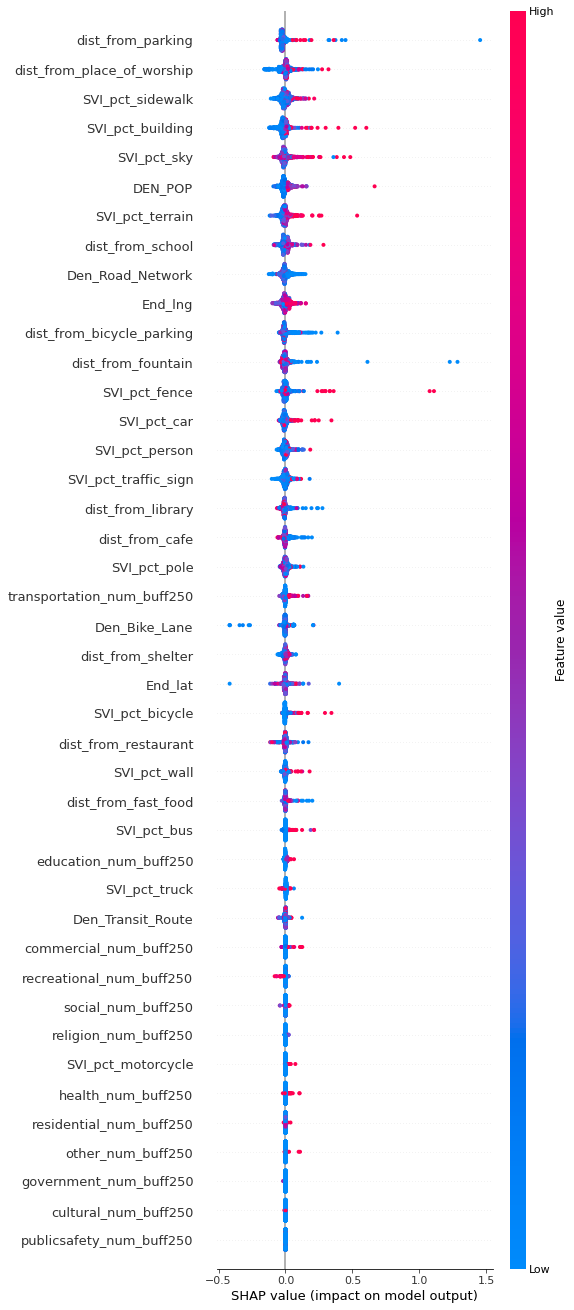

In [14]:
# Feature selection based on XGBoost

var_list = np.array(['End_lat', 'End_lng', 'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250',  'dist_from_school',
       'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_bicycle_parking', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

y = regression_model_input_D_final['ridership']
X = regression_model_input_D_final[var_list]

xgb_model = XGBRegressor(random_state = 100) # , gamma = 0.1
xgb_model.fit(X, y)

# Predict on the test set
y_pred = xgb_model.predict(X)
print('MSE:', mean_squared_error(y, y_pred))
print('R2:', r2_score(y, y_pred))

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, max_display=X.shape[1])

##### LAT, LON, CENSUS

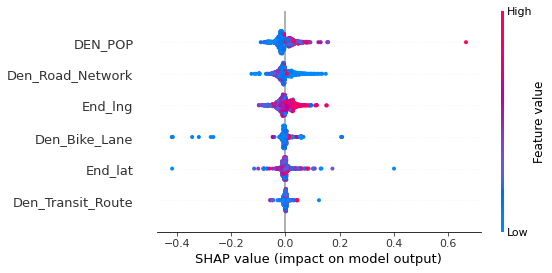

In [15]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 0:6], X.iloc[:, 0:6], max_display=X.shape[1])

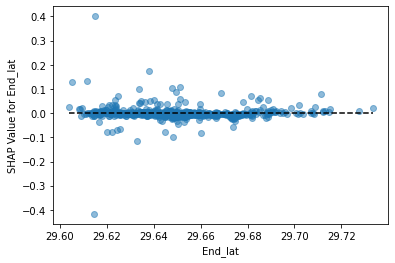

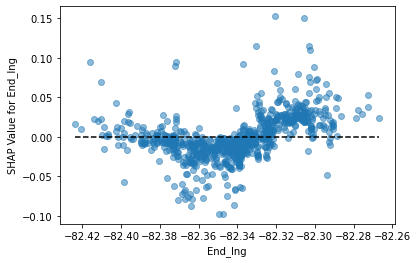

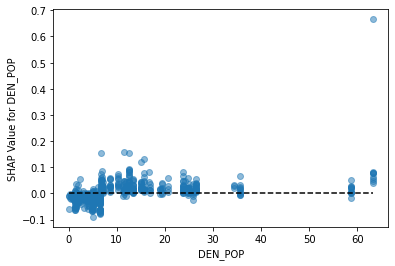

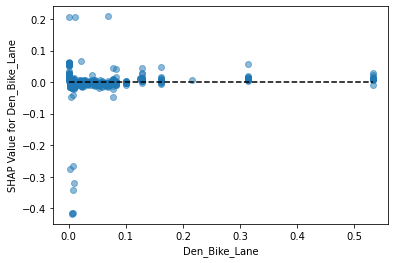

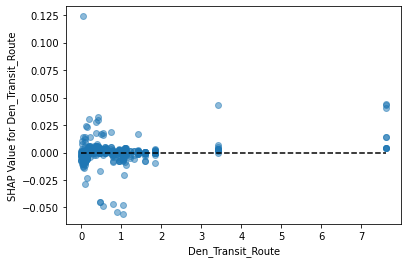

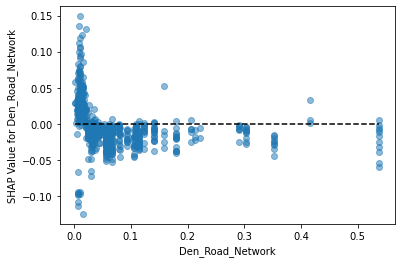

In [16]:
# Plot SHAP values of Feature 0 against the target
for i in range (6):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

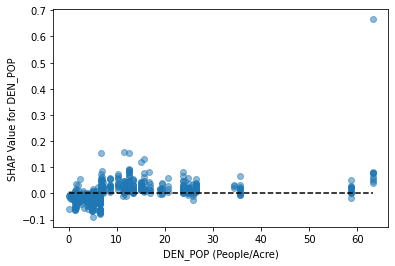

In [17]:
# Plot SHAP values of Feature 0 against the target
i = 2
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(People/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

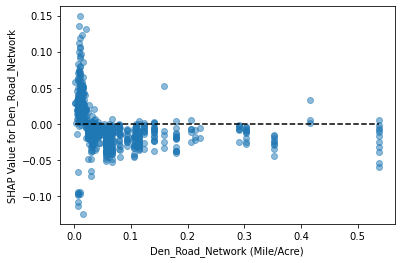

In [18]:
# Plot SHAP values of Feature 0 against the target
i = 5
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

### NUM POI

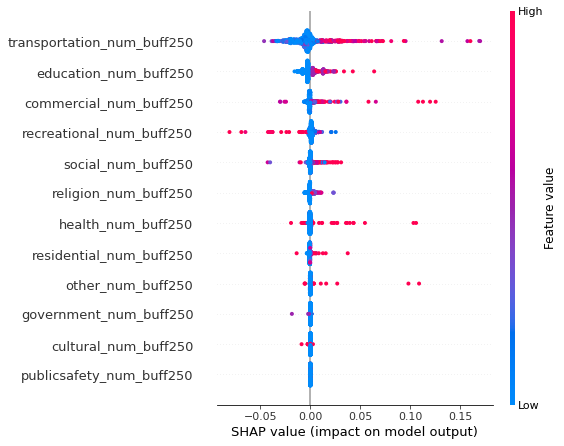

In [19]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 6:18], X.iloc[:, 6:18], max_display=X.shape[1])

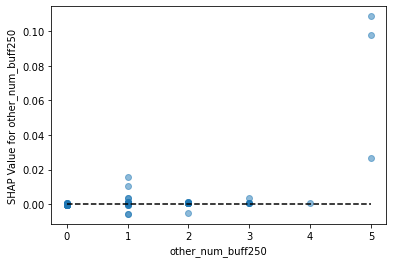

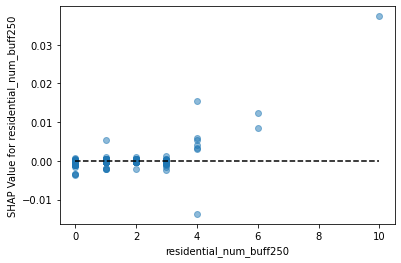

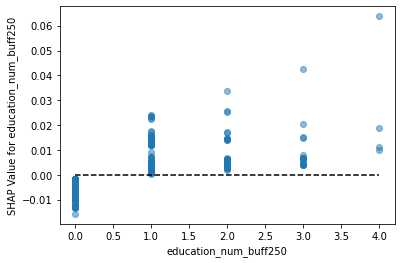

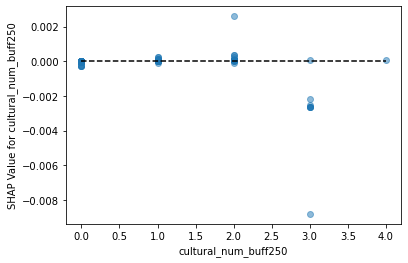

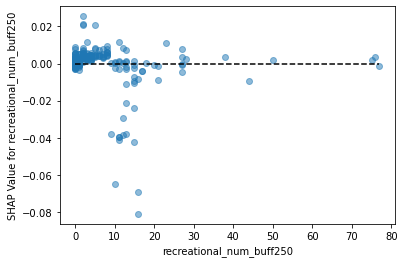

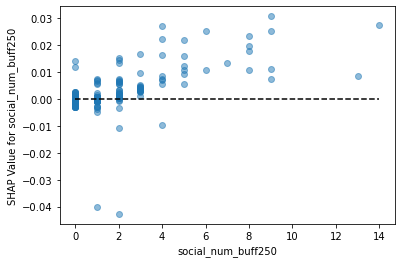

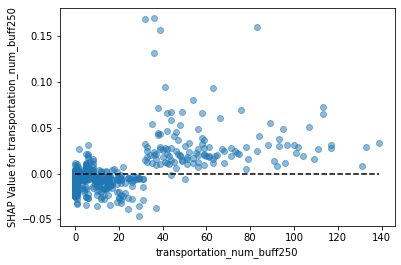

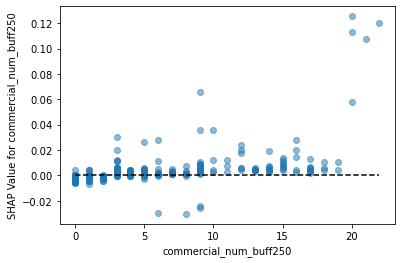

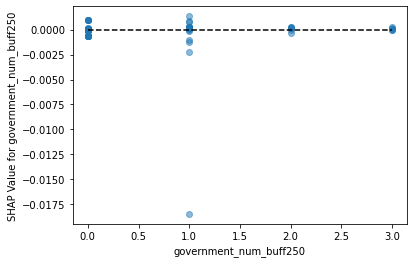

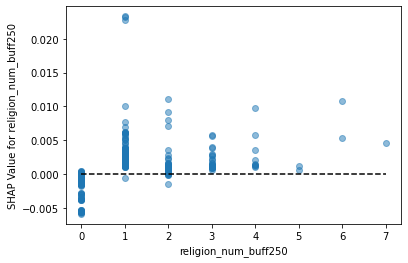

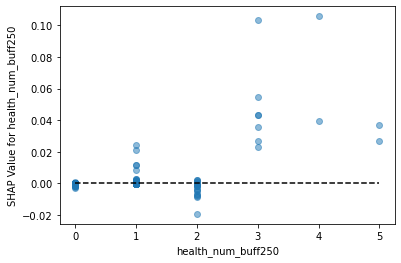

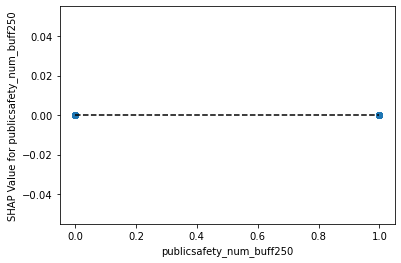

In [20]:
# Plot SHAP values of Feature 0 against the target
for i in range (6, 18):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

### DIST POI

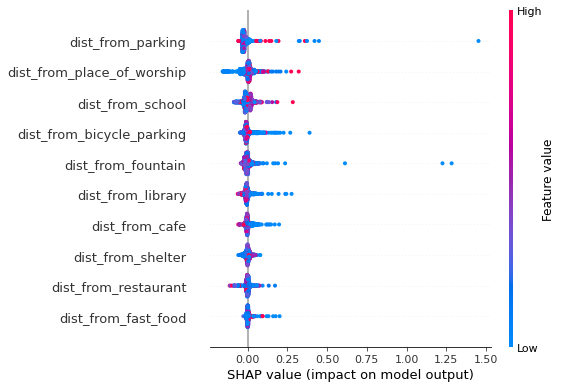

In [21]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 18:28], X.iloc[:, 18:28], max_display=X.shape[1])

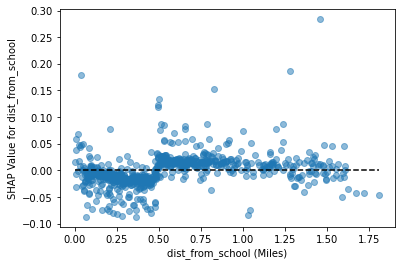

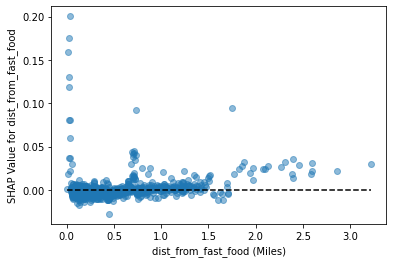

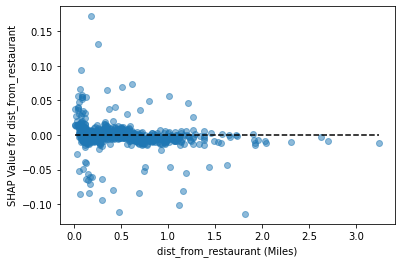

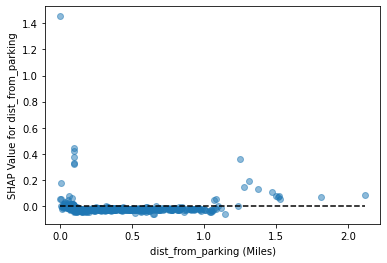

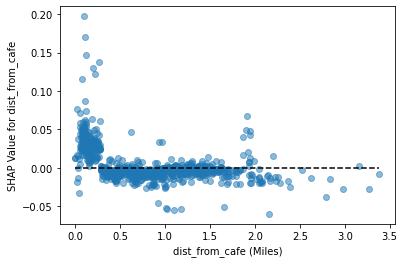

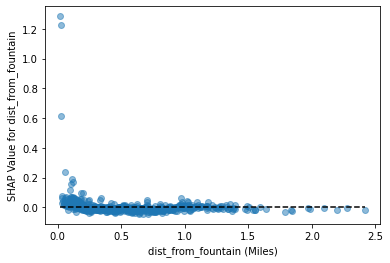

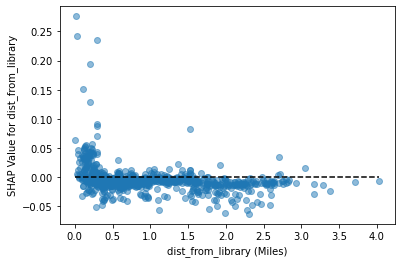

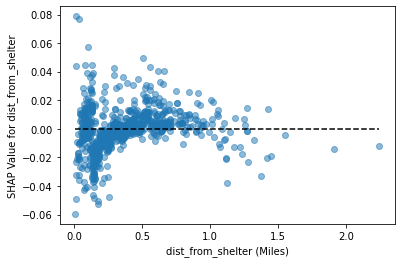

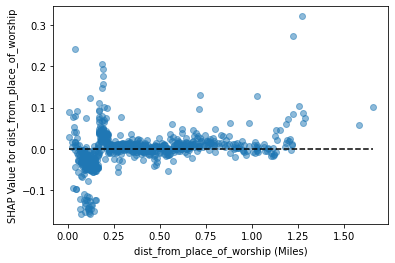

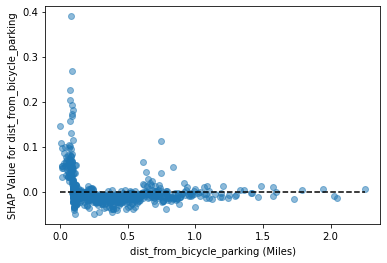

In [22]:
# Plot SHAP values of Feature 0 against the target
for i in range (18, 28):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name + ' ' + '(Miles)')
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

### SVI

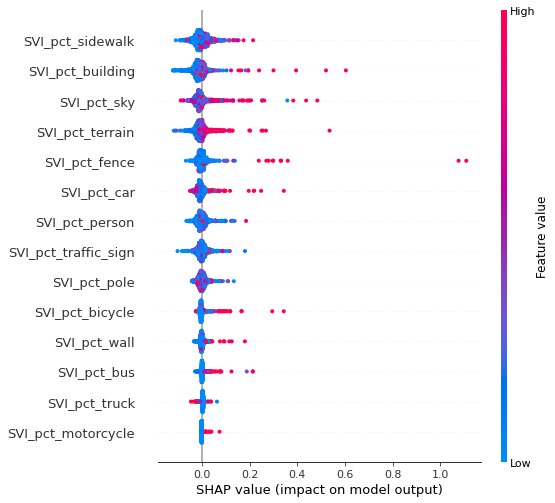

In [23]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 28:], X.iloc[:, 28:], max_display=X.shape[1])

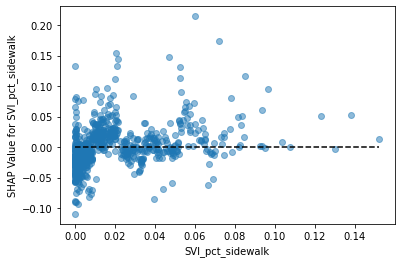

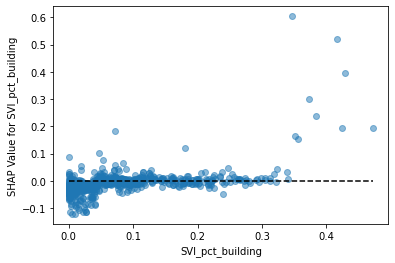

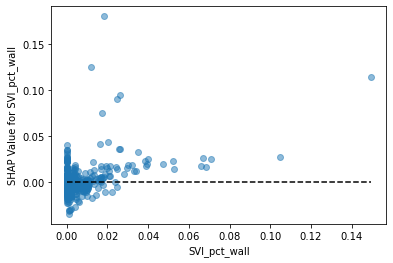

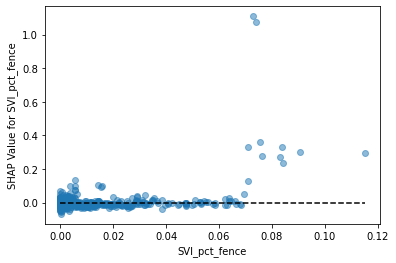

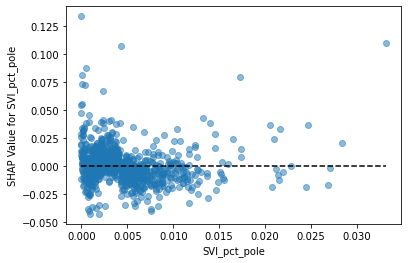

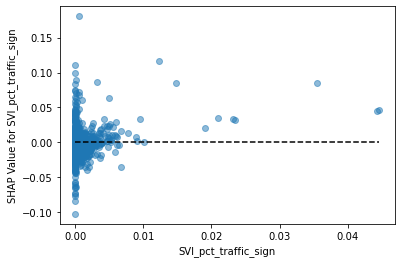

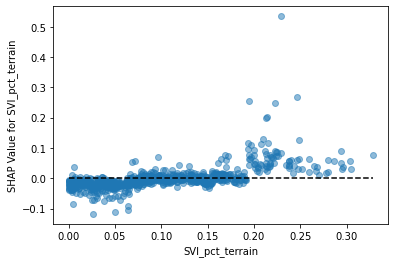

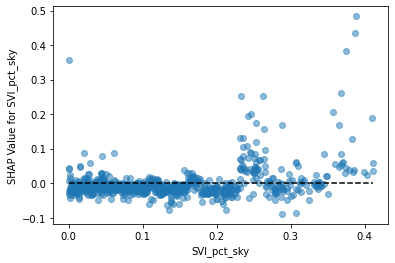

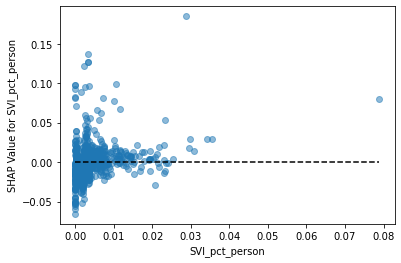

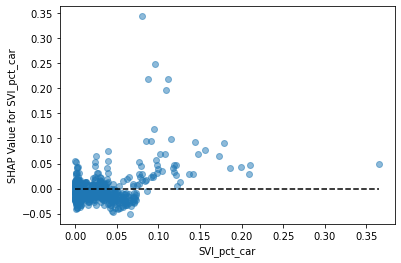

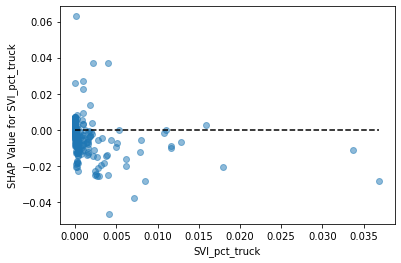

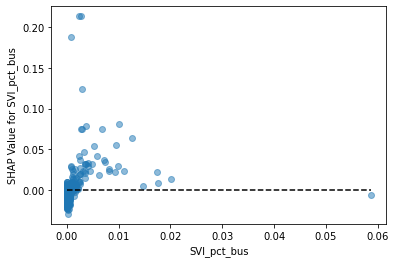

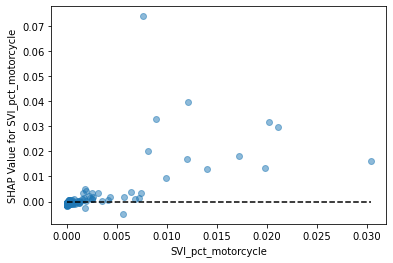

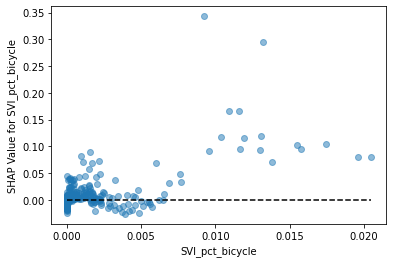

In [24]:
# Plot SHAP values of Feature 0 against the target
for i in range (28, len(var_list)):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()